# The Random Forest Algorithm

The random forest algorithm is a machine learning method that joins multiple decision tree instances to perform classification or regression. Such combinations are known as [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) models. The term 'random forest' is derived from the inverted forest-like appearance of a multiple decision trees joined at the head.

Here we will demonstrate an implementation of both regression (making a prediction based on continuuous data - essentially fancy fitting) and classification (predicting labels of objects based on past experience). Both methods are types of supervised learning, where we train the algorithm on example data.

## Regression using random forest

This example is adapted from an article [here](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0). In this problem we want to predict the maximum temperature for any day in Sydney based on historical data from 2017. Temperature and precipitation data for Sydney may be accessed from [here](https://www.ncdc.noaa.gov/cdo-web/). For convenience we have downloaded the data in comma-separated-variable (CSV) format and placed it in ```DATA/temps.csv```.

Our workflow for this section is:

 * Load the data into a Pandas dataframe
 * Clean the data as required
 * Prepare the data ingestion by the machine learning system
 * Train the model and visualise the training and results
 * Make predictions against a test dataset and assess performance
 * Adjust hyperparameters and retrain
 * Visualise results

### Load the data into a dataframe

A dataframe is a container for tabular data similar to a spreadsheet. It has unique and useful indexing and querying properties.

In [1]:
# Import the Pandas module
import pandas as pd

# Load the data
features = pd.read_csv('DATA/temps.csv')

# Print the dimensions (shape) of the table
print("Table dimensions [rows, columns]:", features.shape)

# Display the first 5 rows
features.head(5)

Table dimensions [rows, columns]: (348, 12)


,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


Following are explanations of the columns:

year: 2016 for all data points

month: number for month of the year

day: number for day of the year

week: day of the week as a character string

temp_2: max temperature 2 days prior

temp_1: max temperature 1 day prior

average: historical average max temperature

actual: max temperature measurement

friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

In [2]:
# Print descriptive stats for each column
features.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


### Plotting the data

Next we want to plot the data for a visual examination. For convenience we will make a function that creates a nicely formatted plot with date on the x-axis and temperature on the y-axis.

In [3]:
# Necessary imports and magic command to display plots inline
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


def plot_trend_ax(ax, df, columnNames = ['actual'], yLabel='Temperature'):
    """Plot multiple trend lines over each other"""
    
    # Select columns years, months and days
    years = df['year'].astype(str)
    months = df['month'].astype(str)
    days = df['day'].astype(str)
    
    # Convert dates to a datetime object
    dateStrLst = ["-".join(x) for x in zip(years, months, days)]
    dates = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in dateStrLst]
    
    # Plot the data
    for colName in columnNames:
        ax.step(dates, df[colName], where='mid', label=colName, linewidth=1)
    ax.set_ylabel('Date')
    ax.set_ylabel(yLabel)
    ax.tick_params(axis='x', rotation=45)
    
    # Enable the legend
    ax.legend(loc='best')
    
    return ax    

/home/cpurcell/.virtualenvs/dl_tf1.15/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


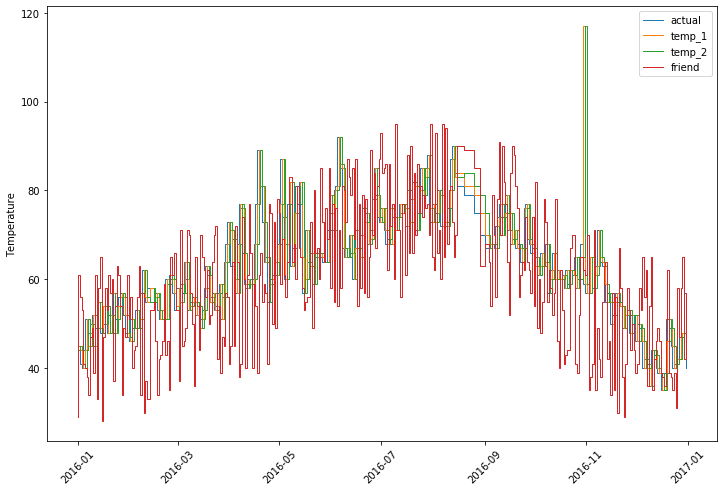

In [4]:
# Initialise the figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# Plot 
plot_trend_ax(ax, features, columnNames=['actual', 'temp_1', 'temp_2', 'friend'])

### Formating the data for use with the tool

The first step for us is known as one-hot encoding of the data. This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering. Days of the week are intuitive to us because we use them all the time. You will (hopefully) never find anyone who doesn’t know that ‘Mon’ refers to the first day of the workweek, but machines do not have any intuitive knowledge. What computers know is numbers and for machine learning we must accommodate them. We could simply map days of the week to numbers 1–7, but this might lead to the algorithm placing more importance on Sunday because it has a higher numerical value. Instead, we change the single column of weekdays into seven columns of binary data. This is best illustrated pictorially. One hot encoding takes this:

In [5]:
# One-hot encode categorical features
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,41,0,0,0,0,0,1,0
